In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import numpy as np 
import datetime

import cartopy.feature as cf
import cartopy.crs as ccrs

import warnings
import os

from google_trans_new import google_translator  
  

warnings.filterwarnings("ignore", category = RuntimeWarning)

from nigthshade import *
from split_filename import *


In [7]:
class GOLD:
    
    def __init__(self, filename, infile = None):
        
        self.infile = infile 
        self.filename = filename
        
        rank = split_filename(self.filename)


        self.dataset = xr.open_dataset(self.infile + self.filename)
        
        if rank.product == 'LIM':
            self.dims = ['n_lat', 'n_alt']
            
            self.dataset.coords['n_alt'] = self.dataset['GRID_ALT'].values
            self.dataset.coords['n_lat'] = self.dataset['GRID_LAT'].values

        else:
            self.dims = ['n_ns', 'n_ew']
        
        self.dataset.coords['n_wavelength'] = self.dataset['WAVELENGTH'].mean(dim = self.dims)
    
    def dataset(self):
        return self.dataset
    

        
    def maximum_value(self, parameter = 'RADIANCE'):

        radiance_avg = self.dataset[parameter].mean(dim = self.dims).values

        wavelength_avg = self.dataset['WAVELENGTH'].mean(dim = self.dims).values
        
        argmax = wavelength_avg[np.argmax(radiance_avg)]

        return self.dataset.sel(n_wavelength = argmax)
    
 
        
    
    def get_1356(self, mean = True):
        """
        1356 brightness map (in Rayleighs) integrates the signal from 133 to 137 nm
        """
        arr = self.dataset['n_wavelength'].values
        
        cond = (arr > 133) & (arr < 137)
        
        result_1356 = np.where(cond, arr, np.nan)
        
        result_1356 = result_1356[~np.isnan(result_1356)]
        
        self.ds = self.dataset.sel(n_wavelength = result_1356)
        
        if mean:
            return self.ds.mean(dim = 'n_wavelength', skipna = True)
        else:
            return self.ds

    
    def get_LBH(self, band = 'total'):
        """
        Individual files:
            Total LBH brightness map (in Rayleighs) integrates the signal from 137 to 155 nm
            with 148.5 to 150.0 nm masked;
        Combined files:
            LBH band 1 brightness map (in Rayleighs) integrates the signal from 140 to 148 nm; 
            LBH band 2 brightness map (in Rayleighs) integrates the signal from 150 to 160 nm. 
        """
        wavelength_values = self.dataset['n_wavelength'].values
        
        if band == 'total':
            start, end = 137, 155
        elif band == 1:
            start, end = 140, 148
        else:
            start, end = 150, 160
        
        cond = (wavelength_values > start) & (wavelength_values < end)
        
        result_LHB = np.where(cond, wavelength_values, np.nan)
        
        result_LHB = result_LHB[~np.isnan(result_LHB)]

        return self.dataset.sel(n_wavelength = result_LHB)
    
    def get_atributes(self):
    
        mirror = self.dataset.attrs['MIRROR_HEMISPHERE']

        if mirror == 'S':
            self.mirror = 'South'
        else:
            self.mirror = 'North'

        self.time_start = pd.to_datetime(self.dataset.attrs['DATE_START']).strftime("%H:%M")

        channel = self.dataset.attrs['INSTRUMENT']

        if channel == 'CHB':
            self.channel = 'Channel B'
        else:
            self.channel = 'Channel A'

        return list((self.mirror, self.time_start, self.channel))



def sep_hemispheres(infile):
    
    """
    Function which sorted files of night disk observations.
    Where combine the channels A and B in each same time 
    """
    _, _, files = next(os.walk(infile))

    diff_channel = [] 

    for i in files:
        for j in files:
            date = split_filename(i).datetime == split_filename(j).datetime
            channel = split_filename(i).channel != split_filename(j).channel
            if date and channel:
                diff_channel.append([j, i])


    equal_files = files[6:19]
    equal_channel = [[equal_files[i], equal_files[i + 1]] for i in range(len(equal_files) - 1)]
    
    return equal_channel[::2] + diff_channel[:6]



def make_table(ax, filenames, infile):
    
    """
    create a table plot (bellow of map) with the informations of 
    hemisphere, TIME UTC of satellite and channel (A or B)
    
    """
    
    #columns names
    columns = ('Hemisphere', 'GOLD UTC', 'Status')

    cell_text = []

    for attrs in filenames:
        ds = GOLD(attrs, infile)
        cell_text.append(ds.get_atributes()) #get_atributes from dataset: hemisphere, time UTC and status

    tab = ax.table(cellText=cell_text, 
                   colLabels=columns, 
                   bbox = (0, -.22, 1, .21)) #xposition, yposition, width, height
    
    tab.set_fontsize(25)
    
    #remove lines from table
    for key, cell in tab.get_celld().items():
            cell.set_linewidth(0)
            
def features_of_map(ax):
    
    ax.set_global()
    ax.gridlines(color = 'grey', linestyle = '--', crs=ccrs.PlateCarree())

    ax.add_feature(cf.NaturalEarthFeature(
                   category='cultural',
                   name='admin_1_states_provinces_lines',
                   scale='50m',
                   facecolor='none'))


    ax.add_feature(cf.COASTLINE, edgecolor='black', lw = 2) 
    ax.add_feature(cf.BORDERS, linestyle='-', edgecolor='black')
    


def magnetic_equator(filename = 'mag_inclination_2021.txt'):
    
    df = pd.read_csv(filename, delim_whitespace = True)

    df = pd.pivot_table(df, columns = 'lon', index = 'lat', values = 'B')
    
    return df.columns.values, df.index.values,  df.values



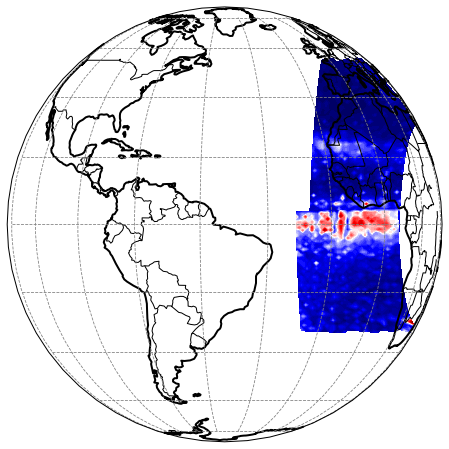

In [20]:

infile  = "C:\\Users\\Luiz Felipe\Downloads\\NI2019111120191112\\tmp\\archive_L1C\\2019\\315\\" 

files = sep_hemispheres(infile)



fig, ax = plt.subplots(figsize = (8, 8),
                       subplot_kw={'projection':ccrs.Orthographic(central_longitude= - 47.5)})




features_of_map(ax)
    


for filename in files[1]:
    
    ds = GOLD(filename, infile).get_1356()

    lats = ds['REFERENCE_POINT_LAT'].values
    lons = ds['REFERENCE_POINT_LON'].values
    data = ds['RADIANCE'].values 

    data[(lats > 50) | (lats < -30)] = np.nan
    
    cmap = 'seismic'
    values = 50

    img  = ax.contourf(lons, lats, data, values,
                                       cmap = cmap, transform = ccrs.PlateCarree())

In [23]:
files[2:-2]

8

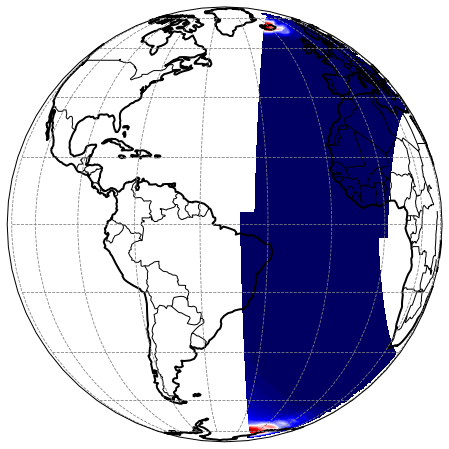

In [99]:
def combine_diff(n, s):
    
    names = n.dims

    #get size of columns and rows in each dataset
    nrows, ncols = n.shape
    srows, scols = s.shape

    if (nrows == srows) and (ncols == scols):
        raise "Both datarrays have the same shape!"

    elif (nrows != srows) and (ncols == scols):

        offset_rows = abs(nrows - srows)
        offset_cols = ncols
        dim = 'n_ns'

        if nrows > srows:
            datarray = s
            least_array = n
        else:
            datarray = n
            least_array = s
    else: 
        offset_rows = nrows
        offset_cols = abs(ncols - scols)
        dim = 'n_ew'

        if ncols > scols:
            datarray = s
            least_array = n
        else:
            datarray = n
            least_array = s


    dumbt = np.empty((offset_rows, offset_cols)) 
    dumbt[:] = np.nan

    new = xr.concat([datarray, xr.DataArray(dumbt, dims=['n_ns', 'n_ew'])], dim = dim)
    

    return np.concatenate((new.values, least_array.values))

data = combine_diff(n, s)
lats = combine_diff(lat_n, lat_s)
lons = combine_diff(lon_n, lon_s)



C:\Users\Luiz Felipe\anaconda3\lib\site-packages\ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


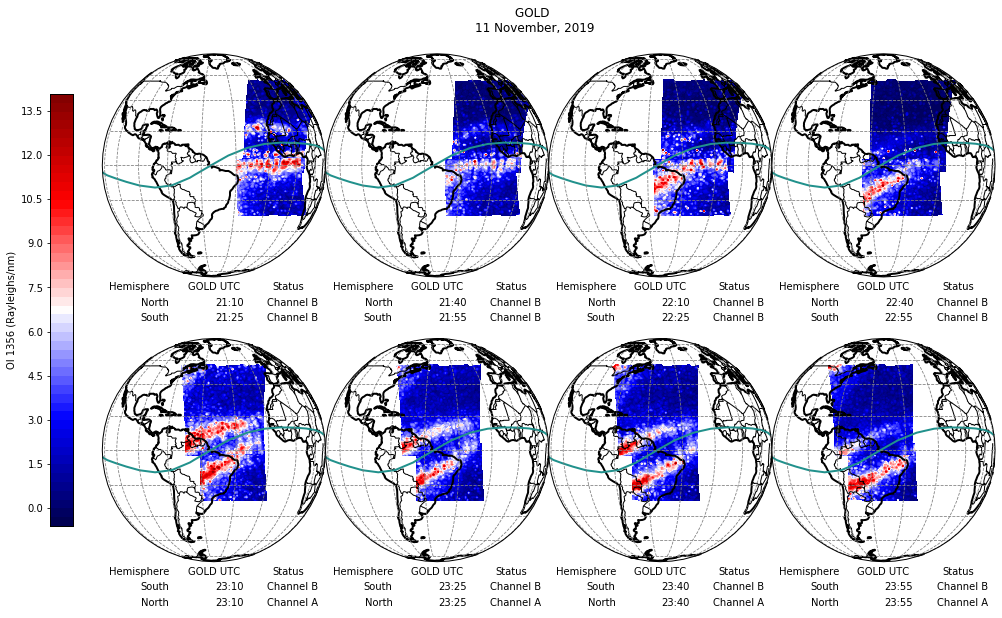

In [24]:
fig, axes = plt.subplots(figsize = (16, 10), nrows = 2, ncols = 4, 
                       subplot_kw={'projection':ccrs.Orthographic(central_longitude= - 47.5)})


plt.subplots_adjust(wspace=0., hspace=0.1)

sorted_files = sep_hemispheres(infile)[2:-2]

title_date = split_filename(sorted_files[0][0]).date()

emission = 'OI 1356'

for ax, files in zip(axes.flat, sorted_files):
    
    features_of_map(ax)
    
    cols, idx, dat = magnetic_equator()

    ax.contour(cols, idx, dat, 1, linewidths = 2, color = 'k',
                       transform = ccrs.PlateCarree())

    for filename in files:

        ds = GOLD(filename, infile).get_1356()

        lats = ds['REFERENCE_POINT_LAT'].values
        lons = ds['REFERENCE_POINT_LON'].values
        data = ds['RADIANCE'].values 


        data[(lats > 50) | (lats < -27)] = np.nan

        cmap = 'seismic'
        values = 50

        img  = ax.contourf(lons, lats, data, values,
                               cmap = cmap, transform = ccrs.PlateCarree())

     
        cbar_ax = fig.add_axes([.08, 0.2, 0.02, 0.6]) #xposition, yposition, ticknness, height

        cb = fig.colorbar(img, cax=cbar_ax, ticklocation='left') 

        cb.set_label(f'{emission} (Rayleighs/nm)') 

        make_table(ax, files, infile)

fig.suptitle('GOLD \n' + title_date, y = .92)    
plt.rcParams.update({'font.size': 14}) 


plt.show()

In [37]:
def figure_name(files, emission):
    
    emission = emission.replace(' ', '_')
    
    if isinstance(files, list):
        
        if len(files) == 2:
            first, second = files[0], files[1]
        else:
            first, second = sorted_files[0][0], sorted_files[-1][-1]
            
        start = split_filename(first)
        end = split_filename(second)
        time_start, time_end = start.time().replace(':',''), end.time().replace(':','')
        date = str(start.date(extent = False)).replace('-', '_')
        
        return f"GOLD_{start.product}_{emission}_{date}_{time_start}_{time_end}"
    else:
        start = split_filename(filename)
        if start.level == 'L2':
             return f"GOLD_{emission.upper()}_{start.level}_{str(start.date(extent = False)).replace('-', '_')}"
        


FigureName = figure_name(sorted_files, emission)

FigureName

'GOLD_NI1_OI_1356_2019_11_11_2110_2355'

In [38]:
PathOut = 'C:\\Users\\Luiz Felipe\\Google Drive\\Doutorado\\Modelos_Latex_INPE\\Figuras1\\'
fig.savefig(PathOut + FigureName + '.png', dpi = 100, quality = 95, bbox_inches="tight")

